# PCA on Scanned Digits

### Michael Frasco 

##### Preliminaries 

In [1]:
sc

In [2]:
import base64
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.mllib.feature import StandardScaler
import math

In [3]:
def parse(x):
    digit = json.loads(x)
    array = np.fromstring(base64.b64decode(digit["data"]),
                          dtype=np.ubyte)
    return (digit["label"], array)

In [4]:
digits = sc.textFile("s3n://stat-37601/digits.base64.json").map(parse)

In [5]:
trainData, testData = digits.randomSplit([0.75, 0.25], 66)

##### Extract Principal Components 

Before we perform the singular value decomposition to get the principal components, we need to standardize our data. I decided to do this my substracting the column means from each image. I did not divide by the standard deviations. One reason behind my choice to do this is that there are a lot of pixels that have standard deviations close to zero, resulting in extremely large normalized values. The results from this process were not desirable. Furthermore, each feature is already on the same scale (0-255), and I did not want to give equal weight to low-variance (i.e. uniformative) pixels.

I created the sample covariance matrix of the data by taking the outer-product of each image. Then I summed all of the rank-one matrices and divided by one. By taking the eigenvalues and eigenvectors of this matrix, I can get the singular values and principal vectors.

In [6]:
trainPixels = trainData.map(lambda x: x[1])
testPixels = testData.map(lambda x: x[1])

In [7]:
trainList = trainPixels.collect()
colMeanVector = np.mean(trainList, axis=0)

In [8]:
deMean = StandardScaler(True, False)
colMeans = deMean.fit(trainPixels)
trainStd = colMeans.transform(trainPixels)
testStd = colMeans.transform(testPixels)

In [9]:
def createMatrix(vector):
    colVec = vector.reshape((784,1))
    return np.dot(colVec, np.transpose(colVec))

In [10]:
sampCovariance = trainStd.map(createMatrix).reduce(lambda x,y: x+y)
n = trainStd.count()
sampCovariance = sampCovariance / n

In [11]:
evalues, evectors = np.linalg.eig(sampCovariance)

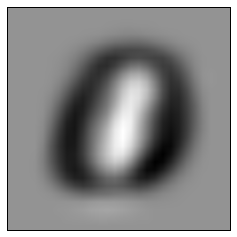

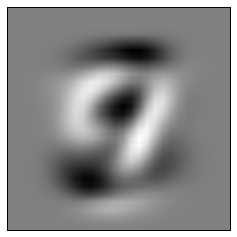

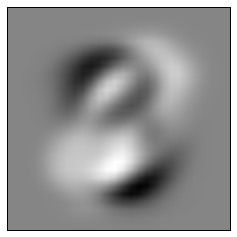

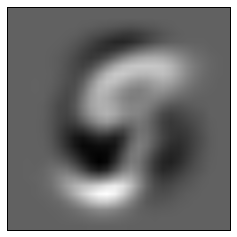

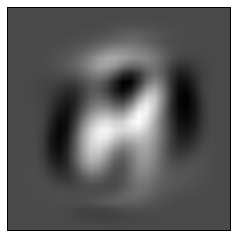

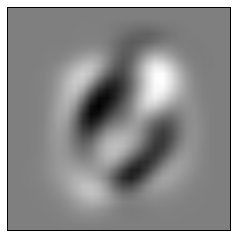

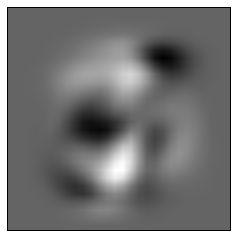

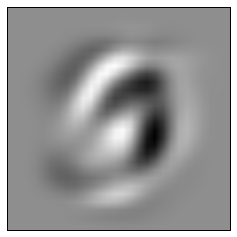

In [12]:
# For some reason, the plotting function doesn't work when I try to
# plot the first 10 principal vectors at once. But it does work,
# when I only plot the first eight. Weird.
for index in range(8):
    image = evectors[:, index]
    image = image.astype(float)/256
    plt.figure(index)
    fig = plt.imshow(image.reshape(28, 28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Interpretation: The first three eigenvectors appear to represent the basic outline of the numbers zero, two, and three. However, it is not advisable to interpret the principal vectors.

##### Plot Variance 

In [13]:
# Why doesnt numpy order the eigenvalues...
orderIndex = np.argsort(evalues)
correctOrder = orderIndex[::-1]

In [14]:
evalues = evalues[correctOrder]
evectors = evectors[correctOrder]
evalues[np.isclose(evalues,0)] = 0
variances = [math.sqrt(x) for x in evalues]

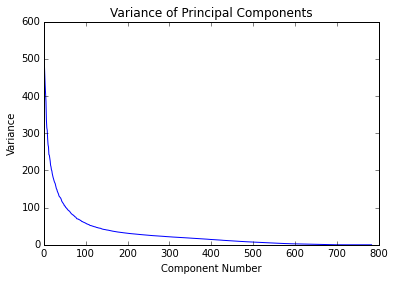

In [15]:
plt.plot(variances)
plt.ylabel("Variance")
plt.xlabel("Component Number")
plt.title("Variance of Principal Components")
plt.show()

The sum of the first k singular values divided by the total sum
is equal to the proportion of variance captured by the first k
principal vectors. This amazing fact is the foundation for dimension
reduction technique. From the plot above, we see that there are a
lot of principal vectors that contribute very little variance.

I implement this function to calculate how many vectors I need
to achive a certain percentage of total variance.

In [16]:
def howManyVectors(percentDesired, values):
    total = sum(values)
    partialSum = 0.0
    numNeeded = 0
    for x in values:
        numNeeded += 1
        partialSum += x
        if partialSum / total > percentDesired:
            return numNeeded
    return len(values)

In [17]:
print howManyVectors(.5, evalues)
print howManyVectors(.75, evalues)
print howManyVectors(.9, evalues)
print howManyVectors(.95, evalues)
print howManyVectors(.99, evalues)

11
34
87
154
331


##### Dimension Reduction 

In [18]:
sampleTestImages = testStd.take(10)

In [19]:
def getReconstruction(image, numComponents, prinVectors):
    mVectors = prinVectors[:, :numComponents]
    reduced = np.dot(image, mVectors)
    reconstructed = np.dot(reduced, np.transpose(mVectors))
    return (image, reconstructed)

In [20]:
# input: an index for our sample test images, our test images,
        # the number of components to use,
        # and the matrix of principal vectors
# output: the reconstructed image and the original test image
def plotReconstructedImage(index, testImages, numComponents, prinVectors):
    testImage = testImages[index]
    testImage, reconstructed = getReconstruction(testImage, numComponents, prinVectors)
    reconstructed = reconstructed + colMeanVector
    reconstructed = reconstructed.astype(float)/256
    plt.figure(1)
    fig = plt.imshow(reconstructed.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    testImage = testImage + colMeanVector
    testImage = testImage.astype(float)/256
    plt.figure(2)
    fig = plt.imshow(testImage.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

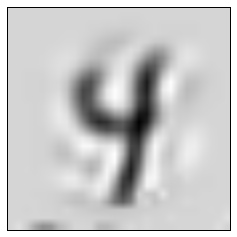

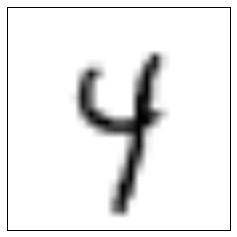

In [23]:
plotReconstructedImage(8, sampleTestImages, 50, evectors)

##### Interpretation

The reconstructed images are fairly accurate when we use more than 30 principal components. 34 principal vectors are needed to capture 75% of the variance, so this makes sense. The representations are exceptional when we use 200 principal vectors, although the background of the image is gray, not white. Certain digits, like "1", are much easier to reconstruct than others. It is very difficult to tell what the first componenents are capturing.

##### Plot Reconstruction Error 

In [24]:
def MSE(x):
    image = x[0]
    reconstruction = x[1]
    return sum((image - reconstruction) ** 2) / len(image)

In [25]:
def getReconstructionError(testData, m, prinVectors):
    return testData.map(lambda x: getReconstruction(x, m, prinVectors)).map(MSE).sum() 

In [26]:
reconstructionErrors = []
for m in range(10, 201, 20):
    reconstructionErrors.append(getReconstructionError(testStd, m, evectors))

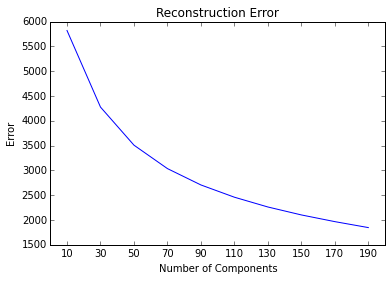

In [27]:
reErrors = [math.sqrt(x) for x in reconstructionErrors]
plt.plot(range(10,201,20),reErrors)
plt.xticks(range(10,201,20))
plt.xlabel("Number of Components")
plt.ylabel("Error")
plt.title("Reconstruction Error")
plt.show()

As expected, the reconstruction error is decreasing in the number of components used. If we use all of the components, the reconstruction error will be zero.